In [55]:
from Pegasus.api import *

In [56]:
from pathlib import Path

import logging

logging.basicConfig(level=logging.DEBUG)

In [57]:
# --- Properties ---------------------------------------------------------------
props = Properties()
props["pegasus.monitord.encoding"] = "json"                                                                    
props["pegasus.mode"] = "tutorial"
props.write() 

In [58]:
# --- Replicas -----------------------------------------------------------------
fa = File("human-1-dna.csv").add_metadata(creator="div")
rc = ReplicaCatalog()\
    .add_replica("local", fa, Path(".").resolve() / "human-1-dna.csv")\
    .write() 

In [59]:
!cat replicas.yml

x-pegasus: {apiLang: python, createdBy: scitech, createdOn: '11-13-23T14:55:40Z'}
pegasus: '5.0'
replicas:
- lfn: human-1-dna.csv
  pfns:
  - {site: local, pfn: /home/scitech/notebooks/01-Introduction-API/human-1-dna.csv}
  metadata: {creator: div}


In [60]:
# --- Transformations ----
split = Transformation(
                "split",
                site="condorpool",
                pfn="/home/scitech/notebooks/01-Introduction-API/split.sh",
                is_stageable=False,
                arch=Arch.X86_64,
                os_type=OS.LINUX
            )

record = Transformation(
                "record",
                site="condorpool",
                pfn="/home/scitech/notebooks/01-Introduction-API/record.sh",
                is_stageable=False,
                arch=Arch.X86_64,
                os_type=OS.LINUX
            )

count = Transformation(
                "count",
                site="condorpool",
                pfn="/home/scitech/notebooks/01-Introduction-API/count.sh",
                is_stageable=False,
                arch=Arch.X86_64,
                os_type=OS.LINUX
            )

tc = TransformationCatalog()\
    .add_transformations(split, record, count)\
    .write()

In [61]:
!cat transformations.yml

x-pegasus: {apiLang: python, createdBy: scitech, createdOn: '11-13-23T14:55:40Z'}
pegasus: '5.0'
transformations:
- name: split
  sites:
  - {name: condorpool, pfn: /home/scitech/notebooks/01-Introduction-API/split.sh,
    type: installed, arch: x86_64, os.type: linux}
- name: record
  sites:
  - {name: condorpool, pfn: /home/scitech/notebooks/01-Introduction-API/record.sh,
    type: installed, arch: x86_64, os.type: linux}
- name: count
  sites:
  - {name: condorpool, pfn: /home/scitech/notebooks/01-Introduction-API/count.sh,
    type: installed, arch: x86_64, os.type: linux}


In [62]:
# --- Workflow -----------------------------------------------------------------
wf = Workflow("dna")

fb = []
fc = []
for i in range(1, 25):
    fb.append("split-" + str(i) + '.csv')
    fc.append("mutation-" + str(i) + '.csv')

    
fd = File("output.txt")

split_job = Job(split)\
            .add_args(fa)\
            .add_inputs(fa)\
            .add_outputs(*fb)

record_jobs = []
for i in range(24):
    record_jobs.append(Job(record)\
            .add_args(fb[i], fc[i])\
            .add_inputs(fb[i])\
            .add_outputs(fc[i]))

count_job = Job(count)\
            .add_args("mutation")\
            .add_inputs(*fc)\
            .add_outputs(fd)


wf.add_jobs(split_job, *record_jobs, count_job)

INFO:Pegasus.api.workflow:dna added Job(_id=ID0000001, transformation=split)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000002, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000003, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000004, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000005, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000006, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000007, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000008, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000009, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000010, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000011, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000012, transformation=record)
INFO:Pegasus.api.workflow:dna added Job(_id=ID0000013, transforma

In [63]:
try:
    wf.write()
    wf.graph(include_files=True, label="xform-id", output="graph.png")
except PegasusClientError as e:
    print(e)

INFO:Pegasus.api.workflow:inferring dna dependencies
INFO:Pegasus.api.workflow:workflow dna with 26 jobs generated and written to workflow.yml

####################
# pegasus-graphviz #
####################


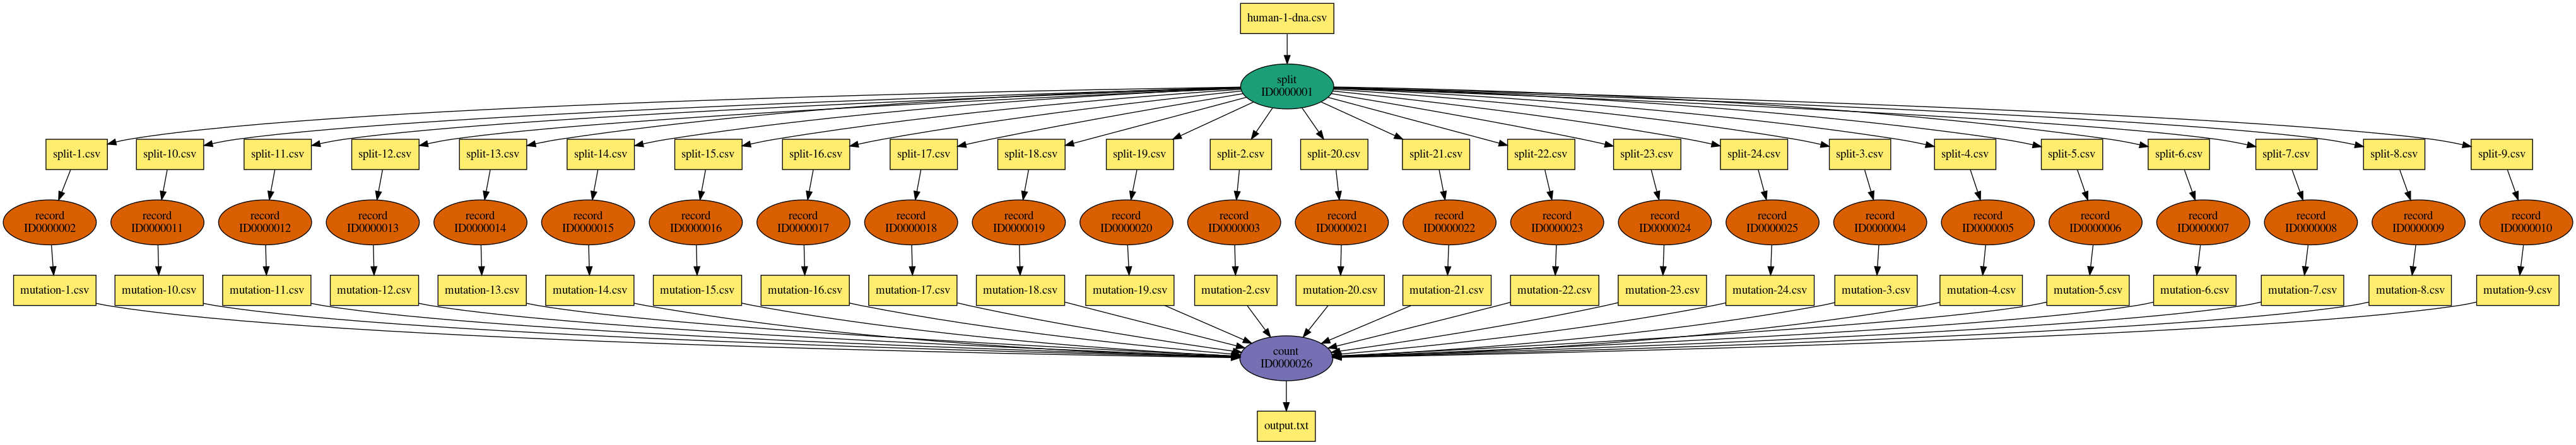

In [64]:
# view rendered workflow
from IPython.display import Image
Image(filename='graph.png')

In [65]:
try:
    wf.plan(submit=True)\
        .wait()
except PegasusClientError as e:
    print(e)


################
# pegasus-plan #
################
2023.11.13 22:55:45.745 UTC:
2023.11.13 22:55:45.754 UTC:   -----------------------------------------------------------------------
2023.11.13 22:55:45.760 UTC:   File for submitting this DAG to HTCondor           : dna-0.dag.condor.sub
2023.11.13 22:55:45.765 UTC:   Log of DAGMan debugging messages                 : dna-0.dag.dagman.out
2023.11.13 22:55:45.771 UTC:   Log of HTCondor library output                     : dna-0.dag.lib.out
2023.11.13 22:55:45.777 UTC:   Log of HTCondor library error messages             : dna-0.dag.lib.err
2023.11.13 22:55:45.783 UTC:   Log of the life of condor_dagman itself          : dna-0.dag.dagman.log
2023.11.13 22:55:45.789 UTC:
2023.11.13 22:55:45.795 UTC:   -no_submit given, not submitting DAG to HTCondor.  You can do this with:
2023.11.13 22:55:45.807 UTC:   -----------------------------------------------------------------------
2023.11.13 22:55:47.571 UTC:   Database version: '5.0.3' (sqlite:

[#########################] 100.0% ..Success (Unready: 0, Completed: 47, Queued: 0, Running: 0, Failed: 0)))


In [66]:
try:
    wf.analyze()
except PegasusClientError as e:
    print(e)


####################
# pegasus-analyzer #
####################
Database version: '5.0.3' (sqlite:////home/scitech/notebooks/01-Introduction-API/scitech/pegasus/dna/run0003/dna-0.stampede.db)

************************************Summary*************************************

Submit Directory   : /home/scitech/notebooks/01-Introduction-API/scitech/pegasus/dna/run0003
Workflow Status    : success
Total jobs         :     47 (100.00%)
# jobs succeeded   :     47 (100.00%)
# jobs failed      :      0 (0.00%)
# jobs held        :      0 (0.00%)
# jobs unsubmitted :      0 (0.00%)



In [67]:
!cat ./wf-output/output.txt 

48
